# Radial Schrödinger equation with local potential

---
This code is made available as part of the **FRIB-TA Summer School: A Practical Walk Through Formal Scattering Theory: Connecting Bound States, Resonances, and Scattering States in Exotic Nuclei and Beyond**, held virtually
August 4-6, 2021.

https://fribtascattering.github.io/

*Organizers/Lecturers:*
- Kévin Fossez (MSU/ANL)
- Sebastian König (NCSU)
- Heiko Hergert (MSU)

*Author:* Sebastian König

*Last update:* Aug 11, 2021

---

We consider here the radial Schrödinger equation written as

\begin{equation}
 \left[\frac{\mathrm{d}^2}{\mathrm{d}r^2} - \frac{l(l+1)}{r^2} - 2\mu V(r) + k^2\right] u(r) = 0 \,.
\end{equation}

Like we did for the Lippmann-Schwinger equation in momentum space, we start by defining our system.  The default sets $m = 2\mu = 1$ and also uses $\hbar = 1$.  For the potential, we also pick the same as in the Lippmann-Schwinger example, an attractive Gaussian with $V_0=-4.0$ and $R=2.0$.

In [1]:
from lib.system import *
from lib.potential import *

sys = System()
V = V_Gauss(sys, -4.0, 2.0)

To solve the **ordinary differential equation (ODE)**, we use `odeint` from `scipy.integrate`:

In [2]:
from scipy.integrate import odeint

The radial Schrödinger equation is a **second order** ODE.  To handle this with the numerical solver, we need to tranform it into a system of first-order ODEs.  To that end, let us first write

\begin{equation}
 u''(r) = \left[\frac{l(l+1)}{r^2} + 2\mu V(r) - k^2\right] u(r) \,,
\end{equation}

and set $v(r) = u'(r)$.  Then we have two coupled first-order equations:

\begin{align}
 u'(r) &= v(r) \\
 v'(r) &= \left[\frac{l(l+1)}{r^2} + 2\mu V(r) - k^2\right] u(r)
\end{align}

This we can now directly turn into an operator defintion as expected by `odeint`:

In [3]:
def radseq(uv, r, k, l):
  u, v = uv
  return [v, (l * (l + 1) / r**2 + 2.0 * sys.mu * V(r) - k**2) * u]

With this, it is straightforward to solve the ODE.  We use here a grid starting essentially at the origin (but avoiding the singularity exactly at $r=0$).  As initial conditions we use $u(0)=0$ and $u'(0)=1$, and we solve for $l=0$ and $k = 1.0$:

In [4]:
import numpy as np

rs = np.linspace(0.0001, 20.0, 1000)

uv0 = [0.0, 1.0]

l = 0
k = 1.0

sol = odeint(radseq, uv0, rs, args=(k, l))

The solution is now a pair of vectors (for $u(r)$ and $v(r)=u'(r)$), stored together in `sol`.  We extract the vector for $u(r)$ and plot it, together with the free solution for comparison:

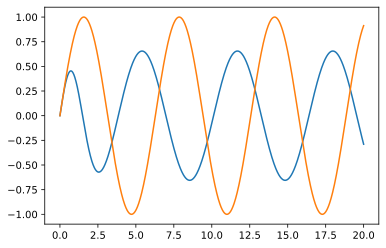

In [5]:
import matplotlib.pyplot as plt

from lib.riccati import *

plt.plot(rs, sol[:, 0])
plt.plot(rs, list(map(lambda r: riccati_j(l, r), rs)))
plt.show()

Finally, we extract the phase shift from

\begin{equation}
 \cot\delta_l(k) = {-}\frac{\hat{n}_l(kr_0)}{\hat{j}_l(kr_0)} \,,
\end{equation}

where $r_0$ is a zero crossing of $u(r)$ satisfying $r_0>R$ (the range of the potential).

Since `numpy` does not provide an `arccot` function, we actually rewrite the above as

\begin{equation}
 \tan\delta_l(k) = {-}\frac{\hat{j}_l(kr_0)}{\hat{n}_l(kr_0)} \,,
\end{equation}

and then use `numpy.arctan`.

In [6]:
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar

u = interp1d(rs, sol[:, 0])

root = root_scalar(u, method='secant', x0=10.0, x1=10.1)
r0 = root.root

print(root)

delta = np.arctan(-riccati_j(l, k * r0) / riccati_n(l, k * r0))

print()
print("delta = %g degrees" % np.rad2deg(delta))

      converged: True
           flag: 'converged'
 function_calls: 5
     iterations: 4
           root: 10.118032232660365

delta = -39.7205 degrees
